# Predicting Service Request Loads

## Loading Time Series Data

The data represents hourly total service requests for 5 weeks, starting with monday.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

#Load the sequence data from CSV
requests = pd.read_csv('requests_every_hour.csv',header=0)

#Review loaded data
print(requests.dtypes)
requests.head()


Requests    int64
dtype: object


,Requests
0,100
1,113
2,162
3,186
4,228


## Time Series Patterns

A time series can have cyclic, seasonal and growth patterns

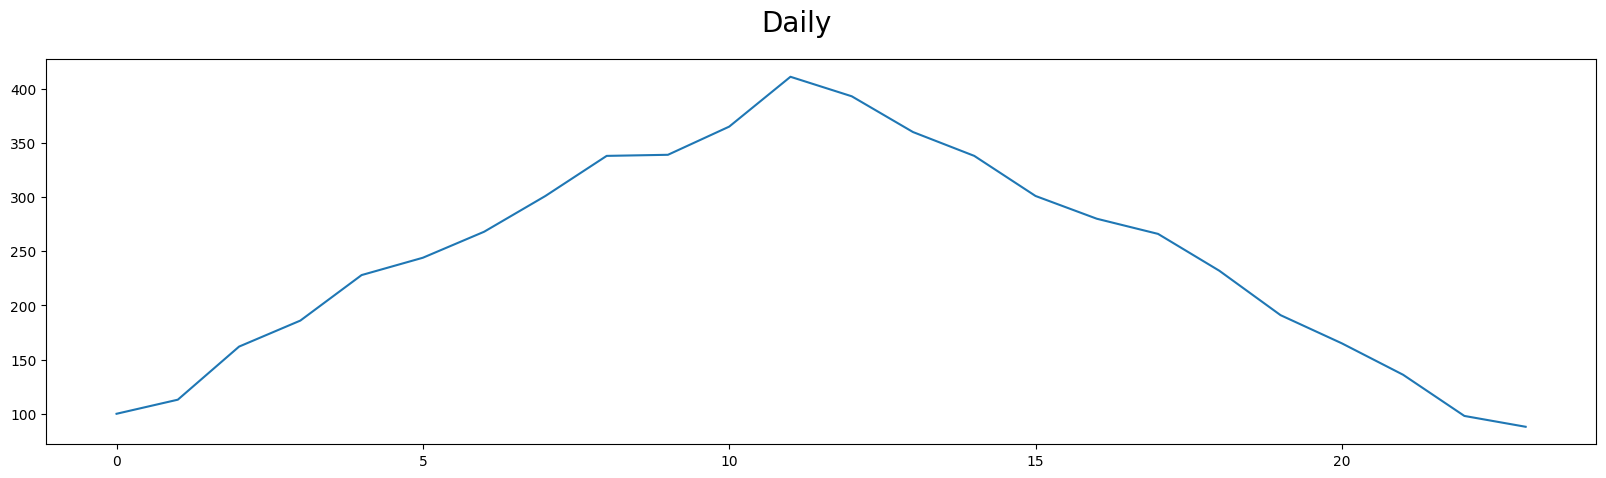

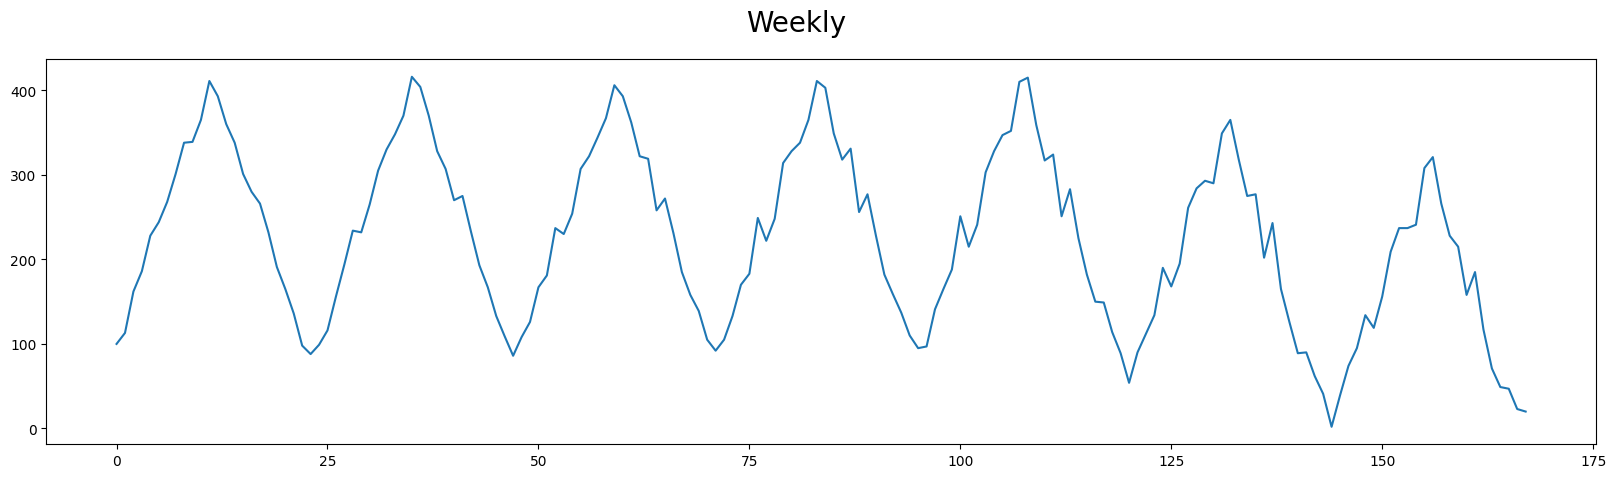

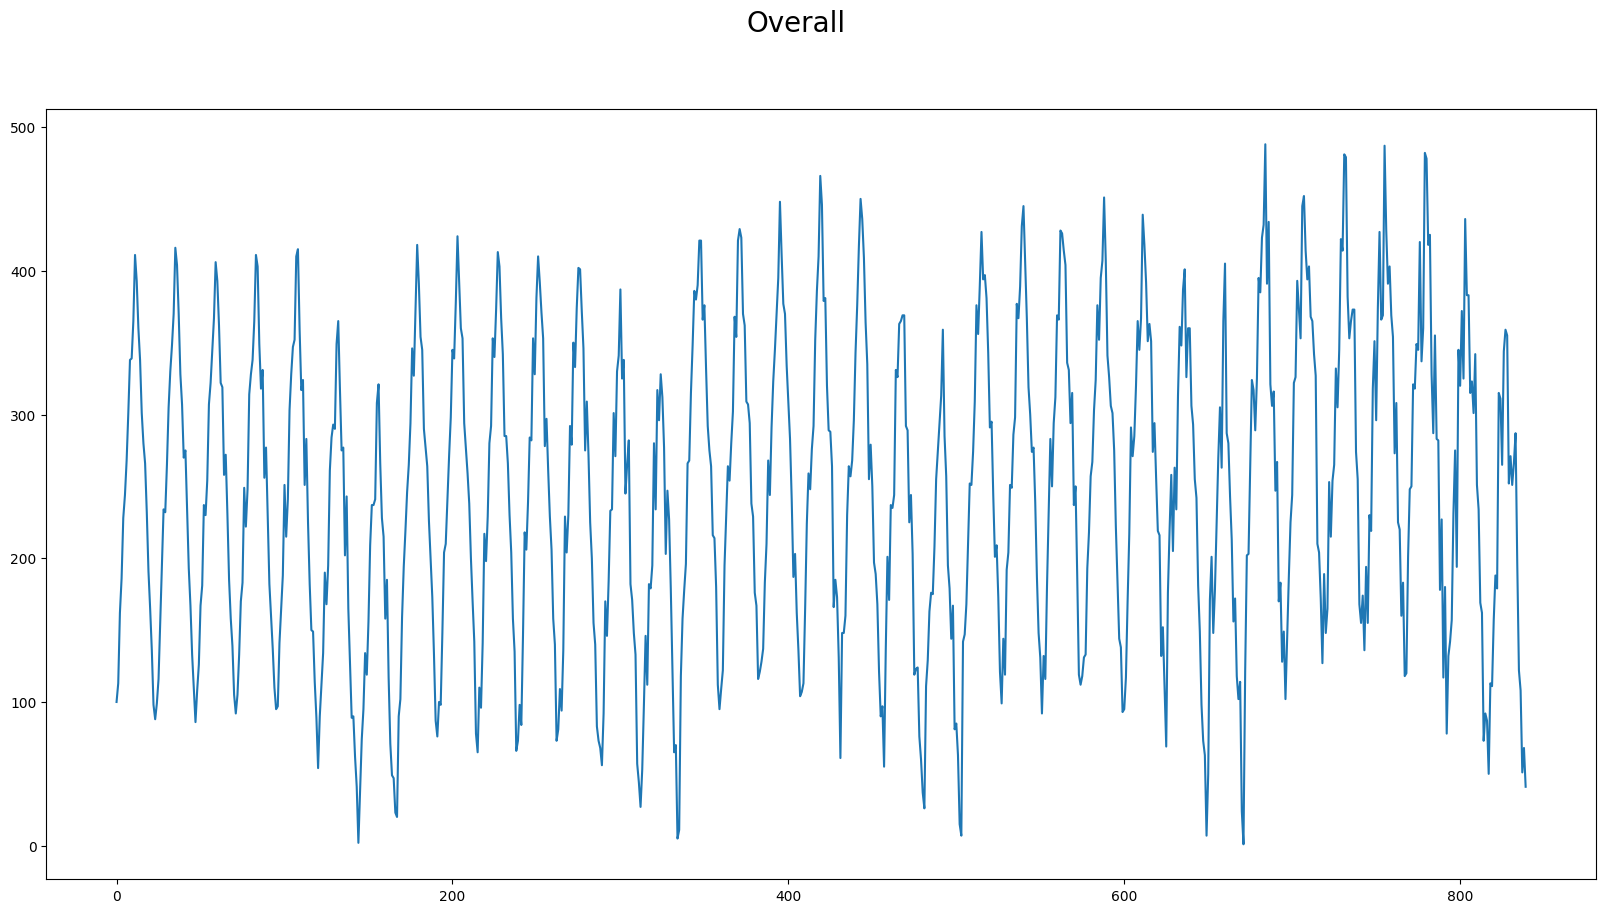

In [15]:
#Plat the data loaded to visualize trends
#daily

plt.figure(figsize=(20,5)).suptitle("Daily", fontsize=20)
plt.plot(requests.head(24))
plt.show()

#weekly
plt.figure(figsize=(20,5)).suptitle("Weekly", fontsize=20)
plt.plot(requests.head(168))
plt.show()

#all
plt.figure(figsize=(20,10)).suptitle("Overall", fontsize=20)
plt.plot(requests)
plt.show()

## Preparing Time Series Data

In [16]:
from sklearn.preprocessing import StandardScaler

#Scale the data
print("Request Range before scaling : " , 
          min(requests.Requests),
          max(requests.Requests))

scaler = StandardScaler()
scaled_requests=scaler.fit_transform(requests)
print("Request Range after scaling : " , 
          min(scaled_requests),
          max(scaled_requests))

#Training data has to be sequencial - first 4 weeks
train_size = 24 * 7 * 4

#Number of samples to lookback for each sample
lookback=24 * 7

#Separate training and test data
train_requests = scaled_requests[0:train_size,:]

#Add an additional week for lookback.
test_requests = scaled_requests[train_size-lookback:,:]

print("\n Shaped of Train, Test : ",
      train_requests.shape, test_requests.shape)

Request Range before scaling :  1 488
Request Range after scaling :  [-2.28221282] [2.23748868]

 Shaped of Train, Test :  (672, 1) (336, 1)


In [17]:
#Prepare RNN Dataset. 
#Each data point (X) is linked to the previous data points of size=lookback
#The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

#Create X and Y for training
train_req_x, train_req_y = create_rnn_dataset(train_requests,lookback)

#Reshape for use with LSTM
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))

print("Shapes of X, Y: ",train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (503, 1, 168) (503,)


##  Build a LSTM model with Keras

In [31]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,GRU
import tensorflow as tf

tf.random.set_seed(3)

#Create a Keras Model
ts_model=Sequential()
#Add LSTM
ts_model.add(LSTM(256, input_shape=(1,lookback)))
ts_model.add(Dense(256, activation='relu'))
ts_model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
ts_model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
ts_model.summary()

#Train the model
ts_model.fit(train_req_x, train_req_y, 
             epochs=5, batch_size=1, verbose=1)

c:\Users\rages\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 256)            │       435,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501,249 (1.91 MB)

 Trainable params: 501,249 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2669 - mse: 0.2669
Epoch 2/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1005 - mse: 0.1005
Epoch 3/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0819 - mse: 0.0819
Epoch 4/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0664 - mse: 0.0664
Epoch 5/5
503/503 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0579 - mse: 0.0579


## Test the Model

In [33]:
#Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(test_requests,lookback)
test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#Evaluate the model
ts_model.evaluate(test_req_x, test_req_y, verbose=1)

#Predict for the training dataset
predict_on_train= ts_model.predict(train_req_x)
#Predict on the test dataset
predict_on_test = ts_model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1365 - mse: 0.1365 
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


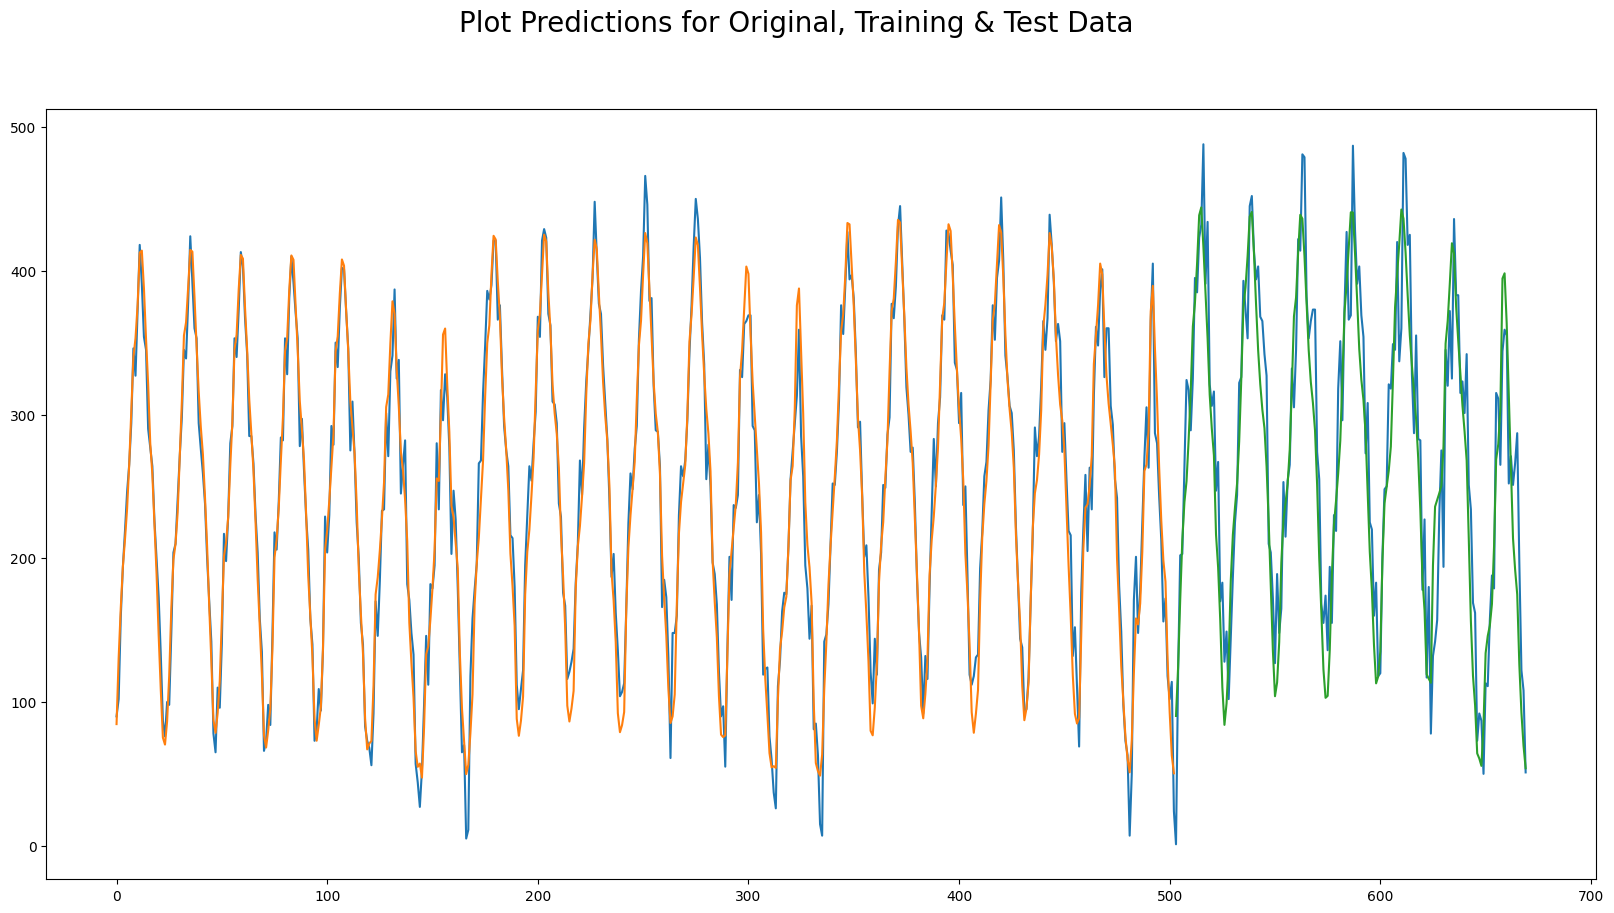

In [34]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train) + len(predict_on_test)

#Plot original data
orig_data=requests.Requests.to_numpy()
orig_data=orig_data.reshape(len(orig_data),1)

#Create a plot for original data
orig_plot = np.empty((total_size,1))
orig_plot[:, :] = np.nan
orig_plot[0:total_size, :] = orig_data[lookback:-2,]

#Create a plot for predictions on training
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Create a plot for predictions on testing
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):total_size, :] = predict_on_test

#Plot the graphs
plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Original, Training & Test Data", fontsize=20)
plt.plot(orig_plot)
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.show()

## Forecasting future Service loads

| Predict | Lookback           |
|:--------------|:-------------------------|
| P1      | A168 - A1          |
| P2      | P1, A168 - A2      |
| P3      | P2 - P1, A168 - A3 |
| P4      | P3 -P1, A168 - A4  |
| P5      | P4 - P1, A168 - A5|

In [35]:
#Use last part of the training data as the initial lookback
curr_input= test_req_x[-1,:].flatten()

#Predict for the next week
predict_for = 24 * 7

for i in range(predict_for):
    
    #Take the last lookback no. of samples as X
    this_input=curr_input[-lookback:]
    #Create the input
    this_input=this_input.reshape((1,1,lookback))
    #Predict for the next point
    this_prediction=ts_model.predict(this_input)

    #Add the current prediction to the input
    curr_input = np.append(curr_input,this_prediction.flatten())

#Extract the last predict_for part of curr_input, which contains all the new predictions
predict_on_future=np.reshape(np.array(curr_input[-predict_for:]),(predict_for,1))

# #Inverse to view results
predict_on_future=scaler.inverse_transform(predict_on_future)

print(predict_on_future[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to calculate MAPE and accuracy in percentage
def calculate_mape(true_values, predicted_values):
    # Avoid division by zero
    true_values = np.where(true_values == 0, np.finfo(float).eps, true_values)
    
    # Calculate MAPE
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    
    # Calculate accuracy
    accuracy = 100 - mape
    
    # Print the results
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    print(f"Accuracy: {accuracy}%")
    
    return mape, accuracy

# Make predictions on the test dataset
predict_on_test = ts_model.predict(test_req_x)

# Inverse the scaling to get original values for both predictions and true values
predict_on_test = scaler.inverse_transform(predict_on_test)
true_values = scaler.inverse_transform(test_req_y.reshape(-1, 1))

# Calculate and print the MAPE and accuracy for the test data
mape, accuracy = calculate_mape(true_values, predict_on_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Absolute Percentage Error (MAPE): 13.884822235300188%
Accuracy: 86.11517776469981%


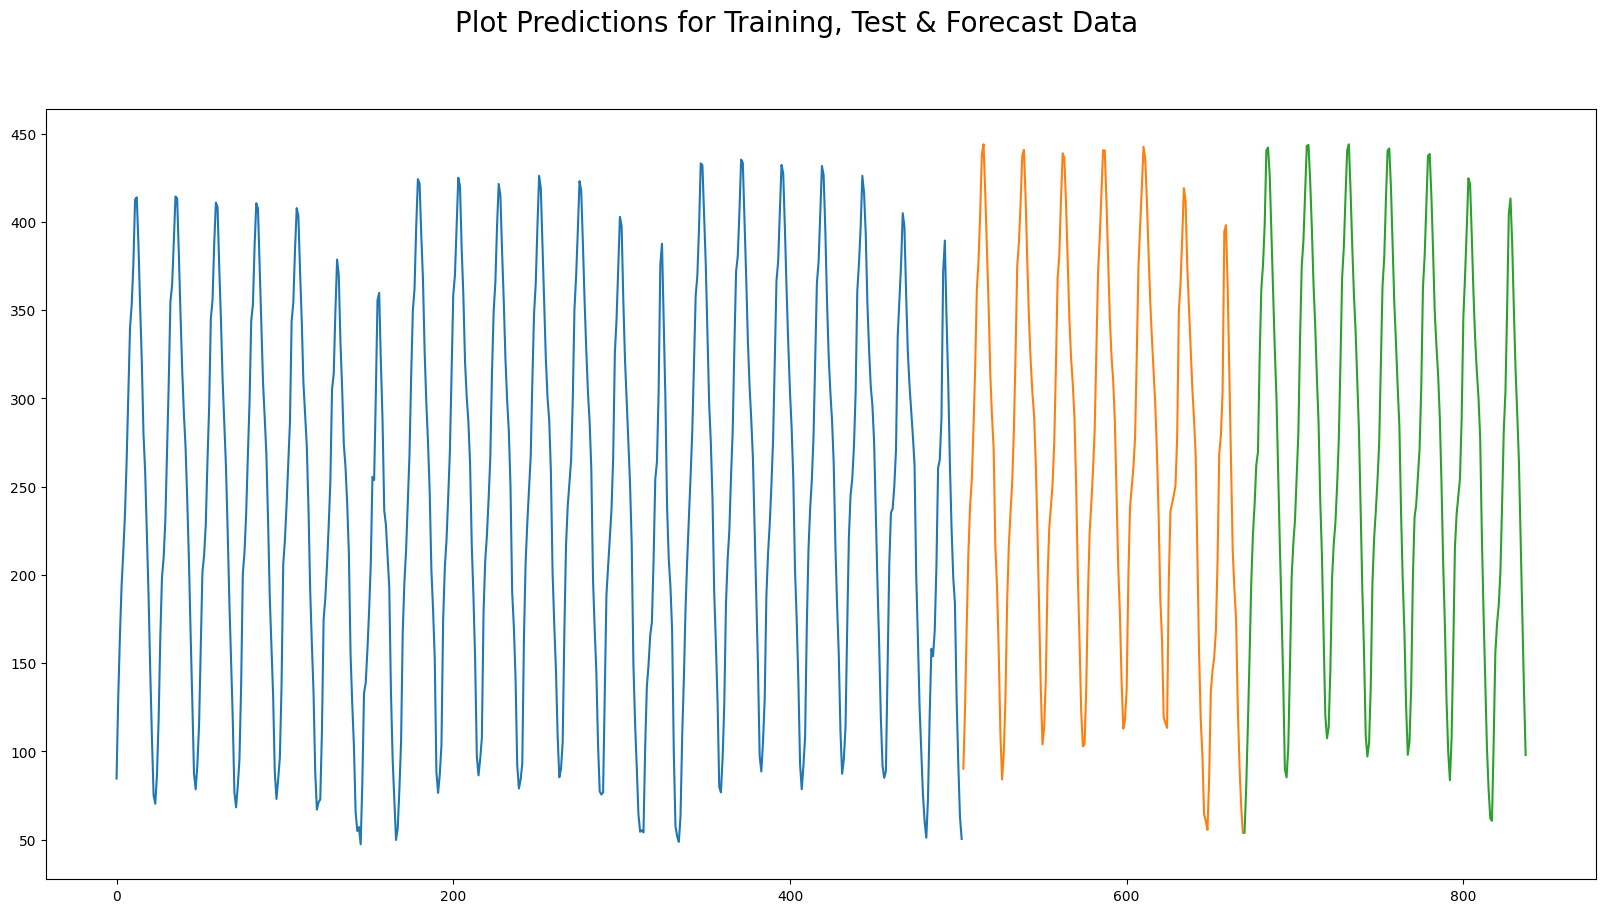

In [37]:
#Plot the training data with the forecast data
total_size = len(predict_on_train) + len(predict_on_test) + len(predict_on_future)

#Setup training chart
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Setup test chart
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test), :] = predict_on_test

#Setup future forecast chart
predict_future_plot = np.empty((total_size,1))
predict_future_plot[:, :] = np.nan
predict_future_plot[len(predict_on_train)+len(predict_on_test):total_size, :] = predict_on_future

plt.figure(figsize=(20,10)).suptitle("Plot Predictions for Training, Test & Forecast Data", fontsize=20)
plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.plot(predict_future_plot)
plt.show()